Target :

- change the architecture to C1C2C3C40 (basically 3 MPs)
- total RF must be more than 44
- one of the layers must use Depthwise Separable Convolution
- one of the layers must use Dilated Convolution
- use GAP (compulsory):- add FC after GAP to target #of classes (optional)
- achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M. 



In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from IPython.display import Image # to display PIL images
import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary

In [3]:
import os
import sys
import os.path as Path

# mount gdrive and unzip data
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  trainer = '/content/gdrive/My Drive/Pytorch/'
  sys.path.insert(0, Path.abspath(trainer))
  print('Added to sys path')
except:
  trainer = '.'
print('Path : ',Path.abspath(trainer))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Added to sys path
Path :  /content/gdrive/My Drive/Pytorch


In [4]:
import numpy as np
## Get mean and std
simple_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
exp = datasets.CIFAR10('./data', train=True, download=True, transform=simple_transforms)
# print(exp, type(exp))
exp_data = exp.data # https://github.com/lyakaap/VAT-pytorch/issues/9
exp_data = exp_data/255.
print('[Train]')
# print(' - Type :', type(exp_data))
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data))
print(' - max:', np.max(exp_data))
mean = np.mean(exp_data, axis=(0,1,2))
std = np.std(exp_data, axis=(0,1,2))
var = np.var(exp_data, axis=(0,1,2))
mean, std = tuple(np.round(mean, 3)) ,tuple(np.round(std, 3))
print(' - mean:', mean)
print(' - std:', std)
print(' - var:', var)


Files already downloaded and verified
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: 0.0
 - max: 1.0
 - mean: (0.491, 0.482, 0.447)
 - std: (0.247, 0.243, 0.262)
 - var: [0.06102492 0.05928501 0.0684282 ]


In [19]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.Resize((32, 32)), # all the data is already in this shape
                                       transforms.RandomAffine(degrees=10, shear = 10),
                                       transforms.ToTensor() ,
                                       transforms.Normalize(mean, std),
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)
                                       ])
# # dataset - Creating train and test/
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


cuda = torch.cuda.is_available()
print('Cuda : ', cuda)
# loaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
device = torch.device("cuda" if cuda else "cpu")

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader   
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


Files already downloaded and verified
Files already downloaded and verified
Cuda :  True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship plane   cat   cat   cat


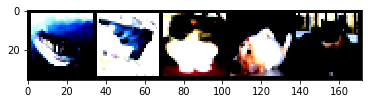

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
visualize_train_loader = torch.utils.data.DataLoader(train_data, batch_size=5,shuffle=True )
dataiter = iter(visualize_train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))


## Model

In [0]:
def conv_block(in_channels, out_channels, dropout=0, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout)
        )
# class DepthwiseSeparableConv(in_channels, out_channels, *args, **kwargs):
#     # https://discuss.pytorch.org/t/depthwise-and-separable-convolutions-in-pytorch/7315/2?u=hemanth346
#     depthwise = nn.Conv2d(in_channels, in_channels*kernel_size, kernel_size=(kernel_size, 1), groups=in_channels, *args, **kwargs)
#     pointwise = nn.Conv2d(in_channels*kernel_size, out_channels, kernel_size=(1, kernel_size), *args, **kwargs)
#     return depthwise, pointwise

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = conv_block(in_channels=3, out_channels=32, kernel_size=3, padding=2, dilation=2, bias=False)      #i:32x32x3    k,n:3,32(3x3x3x32)      o:32x32x32      RF:5      
        self.conv2 = conv_block(in_channels=32, out_channels=64, kernel_size=3, padding=2, dilation=2, dropout=0.1,  bias=False)     #i:32x32x32   k,n:3,64(3x3x32x64)     o:32x32x64      RF:9 
        self.pool = nn.MaxPool2d(2, 2)                                                                                  #i:32x32x64   k,n:2,                  o:16x16x64      RF:10

        self.conv3 = conv_block(in_channels=64, out_channels=64*3, kernel_size=3, padding=1, bias=False, groups=64)     #i:16x16x64   k,n:3,32((3x3x1)64x3)  o:16x16x(64*3)     RF:14
                                                                                                            # Using groups, each group returns 3 channels taking total output to 64x3
        self.conv4 = conv_block(in_channels=64*3, out_channels=128, kernel_size=1, bias=False)                          #i:16x16x(64*3)   k,n:1,128(1x1x32x128)  o:16x16x128     RF:14
        self.pool = nn.MaxPool2d(2, 2)                                                                                  #i:16x16x128   k,n:2,                o:8x8x128      RF:16

        self.conv5 = conv_block(in_channels=128, out_channels=32, kernel_size=1, dropout=0.1, bias=False)                 #i:8x8x128   k,n:1,32(3x3x1x32)   o:8x8x32     RF:16
        self.conv6 = conv_block(in_channels=32, out_channels=64, kernel_size=3, dropout=0.1, padding=1, bias=False)                  #i:8x8x32    k,n:3,64(3x3x32x64)  o:8x8x64     RF:24
        self.conv7 = conv_block(in_channels=64, out_channels=128, kernel_size=3, dropout=0.2, padding=1, bias=False)                 #i:8x8x64   k,n:3,128(3x3x64x128) o:8x8x128    RF:32
        self.pool = nn.MaxPool2d(2, 2)                                                                                  #i:8x8x128   k,n:2,               o:4x4x128    RF:36

        # No relu, BN before GAP/Last layer
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, bias=False)                  #i:4x4x128  k,n:3,64    o:4x4x64    RF:42
        self.gap = nn.AvgPool2d(kernel_size=4)                                                                          #i:4x4x64   k,n:4,      o:1x1x64    RF:46
        self.final = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1, bias=False)                              #i:1x1x64   k,n:1,10    o:1x1x10    RF:60

    def forward(self, x):
        x = self.pool(self.conv2(self.conv1(x)))
        x = self.pool(self.conv4(self.conv3(x)))
        x = self.pool(self.conv7(self.conv6(self.conv5(x))))
        x = self.final(self.gap(self.conv8(x)))
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from engine.trainer import Model
model = Model(Net())

In [23]:
model.summary(input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 192, 16, 16]           1,728
      BatchNorm2d-11          [-1, 192, 16, 16]             384
             ReLU-12          [-1, 192, 16, 16]               0
          Dropout-13          [-1, 192, 16, 16]               0
           Conv2d-14          [-1, 128,

with Wrapper code - Training is not happening, logs at end. Couldn't understand why, everything else seems to be working fine. Will debug and add on to it in coming sessions. Proceeding with regular code

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate (pbar):
    data, target = data.to(device), target.to(device)

    #Don't want history of gradients 
    optimizer.zero_grad()

    y_predict = model(data)

    # Caluclate loss
    loss = F.nll_loss(y_predict, target)
    train_losses.append(loss)

    # Back propogate error
    loss.backward()

    # Take a optimzer step
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_predict.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.4f}')
    train_acc.append(100*correct/processed)


def test (model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [26]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3258291482925415 Batch_id=195 Accuracy=40.2700: 100%|██████████| 196/196 [00:23<00:00,  8.23it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3643, Accuracy: 5135/10000 (51.35%)

EPOCH: 1


Loss=1.2810598611831665 Batch_id=195 Accuracy=56.0240: 100%|██████████| 196/196 [00:25<00:00,  7.83it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.2398, Accuracy: 5480/10000 (54.80%)

EPOCH: 2


Loss=0.951299786567688 Batch_id=195 Accuracy=60.9960: 100%|██████████| 196/196 [00:24<00:00,  8.05it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.0285, Accuracy: 6379/10000 (63.79%)

EPOCH: 3


Loss=1.1525869369506836 Batch_id=195 Accuracy=64.4720: 100%|██████████| 196/196 [00:24<00:00,  8.04it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.0123, Accuracy: 6398/10000 (63.98%)

EPOCH: 4


Loss=1.0739377737045288 Batch_id=195 Accuracy=66.8860: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.9932, Accuracy: 6498/10000 (64.98%)

EPOCH: 5


Loss=0.9211322665214539 Batch_id=195 Accuracy=68.9380: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.9037, Accuracy: 6848/10000 (68.48%)

EPOCH: 6


Loss=0.994349479675293 Batch_id=195 Accuracy=70.4640: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8838, Accuracy: 6918/10000 (69.18%)

EPOCH: 7


Loss=0.7327190041542053 Batch_id=195 Accuracy=71.8000: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7781, Accuracy: 7297/10000 (72.97%)

EPOCH: 8


Loss=0.9323617219924927 Batch_id=195 Accuracy=72.8520: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8623, Accuracy: 6935/10000 (69.35%)

EPOCH: 9


Loss=0.8611952066421509 Batch_id=195 Accuracy=73.8580: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]



Test set: Average loss: 0.7335, Accuracy: 7484/10000 (74.84%)



In [27]:
EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.7397120594978333 Batch_id=195 Accuracy=74.5640: 100%|██████████| 196/196 [00:23<00:00,  8.17it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6958, Accuracy: 7601/10000 (76.01%)

EPOCH: 1


Loss=0.6346017122268677 Batch_id=195 Accuracy=75.6140: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7104, Accuracy: 7548/10000 (75.48%)

EPOCH: 2


Loss=0.6830523610115051 Batch_id=195 Accuracy=75.8520: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7411, Accuracy: 7375/10000 (73.75%)

EPOCH: 3


Loss=0.7622584104537964 Batch_id=195 Accuracy=77.0600: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7205, Accuracy: 7487/10000 (74.87%)

EPOCH: 4


Loss=0.8567411303520203 Batch_id=195 Accuracy=77.2640: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]



Test set: Average loss: 0.6741, Accuracy: 7644/10000 (76.44%)



In [28]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.7928823828697205 Batch_id=195 Accuracy=79.9440: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6081, Accuracy: 7874/10000 (78.74%)

EPOCH: 1


Loss=0.6650717854499817 Batch_id=195 Accuracy=80.7920: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6050, Accuracy: 7902/10000 (79.02%)

EPOCH: 2


Loss=0.7157143354415894 Batch_id=195 Accuracy=80.7140: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5902, Accuracy: 7960/10000 (79.60%)

EPOCH: 3


Loss=0.7223192453384399 Batch_id=195 Accuracy=81.1160: 100%|██████████| 196/196 [00:23<00:00,  8.24it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5931, Accuracy: 7928/10000 (79.28%)

EPOCH: 4


Loss=0.6231173276901245 Batch_id=195 Accuracy=81.0920: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]



Test set: Average loss: 0.5955, Accuracy: 7931/10000 (79.31%)



In [29]:
EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.6815000772476196 Batch_id=195 Accuracy=81.3340: 100%|██████████| 196/196 [00:23<00:00,  8.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5901, Accuracy: 7969/10000 (79.69%)

EPOCH: 1


Loss=0.7351314425468445 Batch_id=195 Accuracy=81.3500: 100%|██████████| 196/196 [00:25<00:00,  7.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5896, Accuracy: 7941/10000 (79.41%)

EPOCH: 2


Loss=0.6365833878517151 Batch_id=195 Accuracy=81.5680: 100%|██████████| 196/196 [00:23<00:00,  8.17it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5840, Accuracy: 7965/10000 (79.65%)

EPOCH: 3


Loss=0.3847526013851166 Batch_id=195 Accuracy=81.5360: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5861, Accuracy: 7979/10000 (79.79%)

EPOCH: 4


Loss=0.7014423608779907 Batch_id=195 Accuracy=81.4960: 100%|██████████| 196/196 [00:23<00:00,  8.20it/s]



Test set: Average loss: 0.5833, Accuracy: 7985/10000 (79.85%)



In [30]:
optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)
EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.42192044854164124 Batch_id=195 Accuracy=81.8800: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5830, Accuracy: 7968/10000 (79.68%)

EPOCH: 1


Loss=0.5730381608009338 Batch_id=195 Accuracy=82.0700: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5801, Accuracy: 7990/10000 (79.90%)

EPOCH: 2


Loss=0.49251270294189453 Batch_id=195 Accuracy=82.0580: 100%|██████████| 196/196 [00:23<00:00,  8.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5789, Accuracy: 8005/10000 (80.05%)

EPOCH: 3


Loss=0.4705830216407776 Batch_id=195 Accuracy=82.2760: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5815, Accuracy: 8087/10000 (80.87%)

EPOCH: 4


Loss=0.617595374584198 Batch_id=195 Accuracy=82.1840: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]



Test set: Average loss: 0.5787, Accuracy: 8083/10000 (80.83%)



Text(0.5, 1.0, 'Test Accuracy')

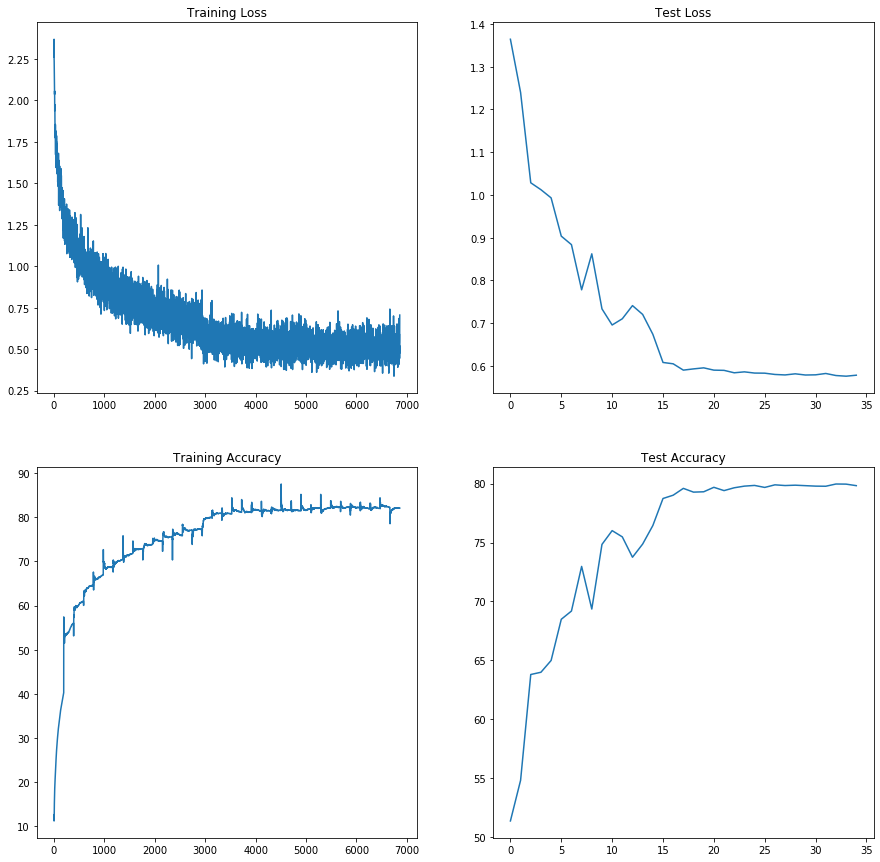

In [32]:
    fig, axs = plt.subplots(2,2,figsize=(15,15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Using wrapper

In [24]:
optimizer = optim.SGD(Net().parameters(), lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='nll_loss')

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
) nll_loss 0


In [25]:
for epoch in range(5):
    print(f'Epoch  : {epoch}')
    model.train(train_loader)
    model.eval(test_loader)
    # model.epochs += 1

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch  : 0


Loss=2.3362503051757812 Batch_id=390 Accuracy=10.03: 100%|██████████| 391/391 [00:15<00:00, 25.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3435, Accuracy: 1001/10000 (10.01%)

Epoch  : 1


Loss=2.343193292617798 Batch_id=390 Accuracy=10.03: 100%|██████████| 391/391 [00:15<00:00, 25.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3430, Accuracy: 1001/10000 (10.01%)

Epoch  : 2


Loss=2.332897663116455 Batch_id=390 Accuracy=10.03: 100%|██████████| 391/391 [00:15<00:00, 25.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3428, Accuracy: 1002/10000 (10.02%)

Epoch  : 3


Loss=2.3632729053497314 Batch_id=390 Accuracy=10.03: 100%|██████████| 391/391 [00:15<00:00, 25.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3434, Accuracy: 1002/10000 (10.02%)

Epoch  : 4


Loss=2.34356689453125 Batch_id=390 Accuracy=10.03: 100%|██████████| 391/391 [00:15<00:00, 25.55it/s]



Test set: Average loss: 2.3430, Accuracy: 1001/10000 (10.01%)



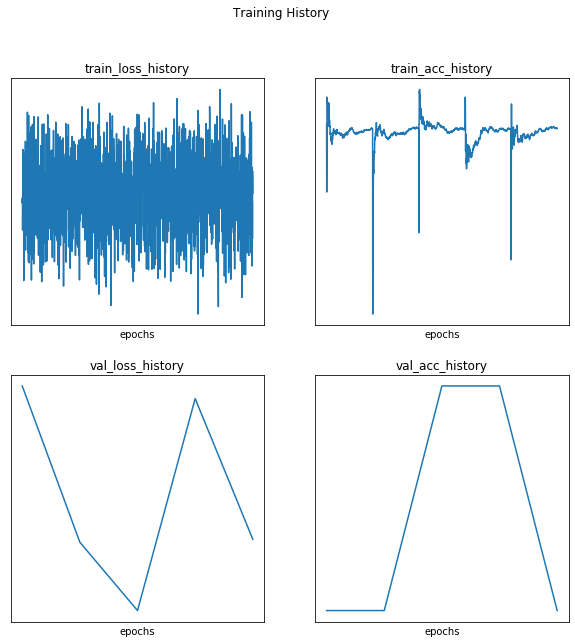

In [26]:
model.plot_history()

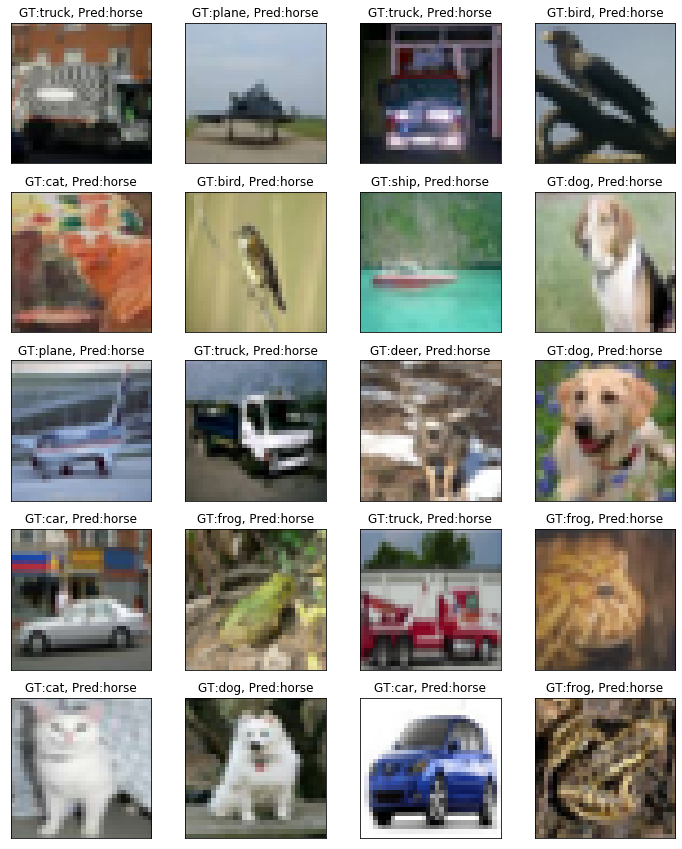

In [27]:
model.plot_misclassified(test_loader, labels=classes, mean=mean, std=std)